In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

# Sampling from two different gaussian distributions

In [5]:
mu_centered, sigma_centered = 0, 0.1
s_normal_centered = np.random.normal(mu_centered, sigma_centered, 1000)

mu_shifted, sigma_shifted = 10, 0.2
s_normal_shifted = np.random.normal(mu_shifted, sigma_shifted, 1000)

μ_centered =-0.0012125687548305616
σ_centered =0.0956561330785438
μ_shifted =9.99911756586266
σ_shifted =0.20035067228270248


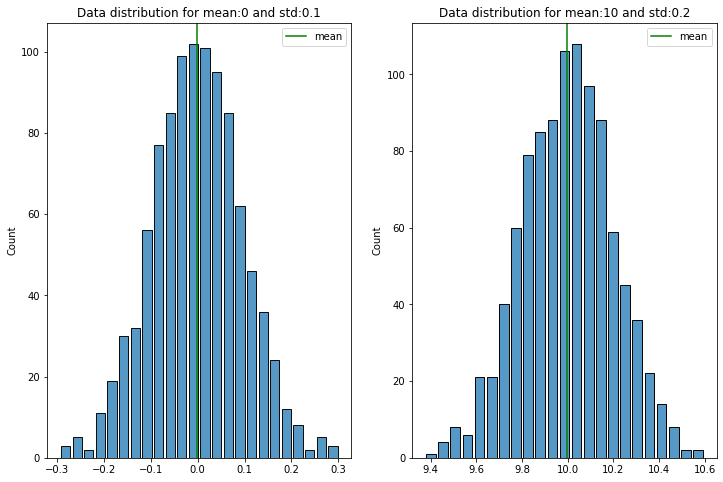

In [6]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal_centered, ax=axis[0], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_centered} and std:{sigma_centered}")
axis[0].axvline(s_normal_centered.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_normal_shifted, ax=axis[1], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_shifted} and std:{sigma_shifted}")
axis[1].axvline(s_normal_shifted.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal_centered.mean()}')
print(f'σ_centered ={s_normal_centered.std()}')
print(f'μ_shifted ={s_normal_shifted.mean()}')
print(f'σ_shifted ={s_normal_shifted.std()}')


# Data sets generation

In [7]:
# sample 90% from centered dataset
centered_dist = random.sample(list(s_normal_centered), 900)
normal_points = ["no" for e in centered_dist]

# sample 1% from shifted dataset 
shifted_dist = random.sample(list(s_normal_shifted), 100)
outliers = ["yes" for e in shifted_dist]

numbers = centered_dist + shifted_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   float64
 1   label_gt          1000 non-null   object 
 2   numeric_label_gt  1000 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [9]:
df.head()

,number,label_gt,numeric_label_gt
0,0.171498,no,1
1,0.009243,no,1
2,0.225931,no,1
3,-0.040524,no,1
4,0.051207,no,1


In [10]:
df.tail()

,number,label_gt,numeric_label_gt
995,10.128415,yes,-1
996,9.657506,yes,-1
997,10.098828,yes,-1
998,9.950333,yes,-1
999,10.042206,yes,-1


In [11]:
df.describe()

,number,numeric_label_gt
count,1000.000000,1000.0000
mean,0.997699,0.8000
std,3.002156,0.6003
min,-0.294981,-1.0000
25%,-0.056693,1.0000
50%,0.014221,1.0000
75%,0.088544,1.0000
max,10.341034,1.0000


In [12]:
# The frac keyword argument specifies the fraction of rows to return in the random sample, 
# so frac=1 means to return all rows (in random order
df = df.sample(frac=1)

# Isolation Forest

In [26]:
# Train IF, K-means, RF, SVDD? 
from sklearn.ensemble import IsolationForest

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")
print(df['anomaly'].value_counts())
(df["anomaly"] == df["label_gt"]).value_counts()

no     900
yes    100
Name: anomaly, dtype: int64


True     936
False     64
dtype: int64

## Using Grid Search to find the best set of parameters for IF

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

my_scoring_func = make_scorer(f1_score)
parameters = {'n_estimators':[10,30,50,80,100], 
            'max_features':[0.1,0.2,0.3,0.4,1.0], 
            'contamination' : [0.1,0.2]
            }
isolation_forest =  IsolationForest(max_samples='auto')
search = GridSearchCV(isolation_forest, parameters,  scoring=my_scoring_func)
search.fit(df[['number']], df[['numeric_label_gt']])

GridSearchCV(estimator=IsolationForest(),
             param_grid={'contamination': [0.1, 0.2],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 1.0],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring=make_scorer(f1_score))

In [16]:
result_search_df = pd.DataFrame(search.cv_results_)
best_estimators = result_search_df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()
print(f"Best estimator parameters: {best_estimators.iloc[0]['params']}")

Best estimator parameters: {'contamination': 0.1, 'max_features': 0.1, 'n_estimators': 50}


In [17]:
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(df[['number']])

h = (pred == df['numeric_label_gt']).value_counts()

In [18]:
# Visualize results
df

,number,label_gt,numeric_label_gt,scores,anomaly
750,-0.003766,no,1,0.195407,no
801,0.034598,no,1,0.200649,no
56,-0.080466,no,1,0.194599,no
822,-0.029607,no,1,0.198924,no
881,-0.073831,no,1,0.192150,no
...,...,...,...,...,...
45,0.014236,no,1,0.203128,no
973,10.105707,yes,-1,0.008775,no
910,10.166913,yes,-1,-0.012610,yes
510,-0.173941,no,1,0.081632,no


# Sampling from two different distributions: Gaussian and Poisson

In [19]:
mu_gau, sigma_gau = 0, 0.1
s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_poisson = np.random.poisson(5, 1000)

μ_centered =-0.0039892185287988295
σ_centered =0.09808480933758218
μ_shifted =5.046
σ_shifted =2.2284263505891326


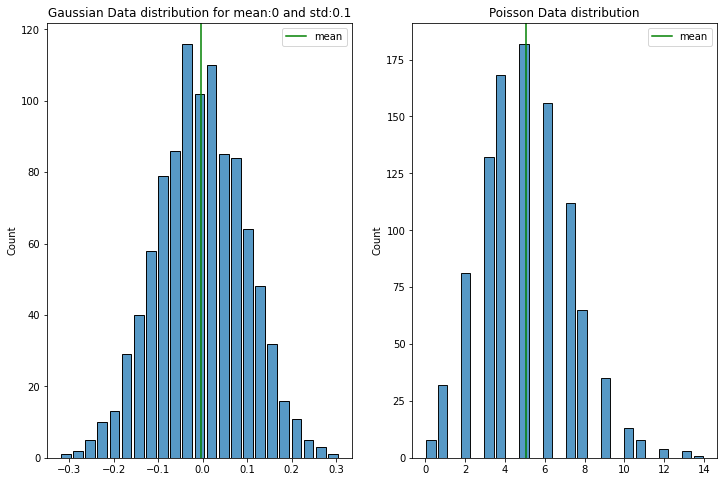

In [23]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_poisson, ax=axis[1], shrink=0.8, stat='count').set(title=f"Poisson Data distribution")
axis[1].axvline(s_poisson.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_poisson.mean()}')
print(f'σ_shifted ={s_poisson.std()}')

In [32]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 1% from shifted dataset 
poisson_dist = random.sample(list(s_poisson), 100)
outliers = ["yes" for e in poisson_dist]

numbers = gaus_dist + poisson_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [33]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")
print(df['anomaly'].value_counts())
print(f"predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

no     923
yes     77
Name: anomaly, dtype: int64
predictions: 
 True     973
False     27
dtype: int64


# Sampling from two different distributions: Gaussian and standard_cauchy

In [46]:
mu_gau, sigma_gau = 0, 0.1

s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_std_cauchy = np.random.standard_cauchy(1000)
# truncate distribution so it plots well
s_std_cauchy = s_std_cauchy[(s_std_cauchy>-25) & (s_std_cauchy<25)]
len(s_std_cauchy)

970

μ_centered =0.0020957275277453252
σ_centered =0.09999095451456079
μ_shifted =-0.1231161584875045
σ_shifted =4.3014932516153905


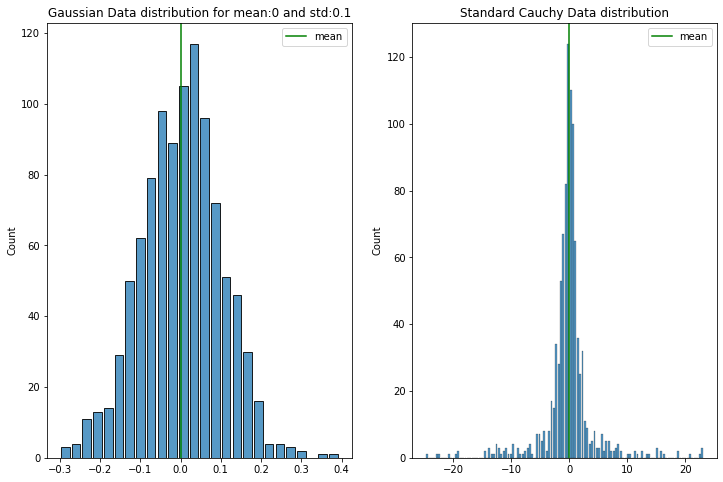

In [47]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_std_cauchy, ax=axis[1], shrink=0.8, stat='count').set(title=f"Standard Cauchy Data distribution")
axis[1].axvline(s_std_cauchy.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_std_cauchy.mean()}')
print(f'σ_shifted ={s_std_cauchy.std()}')

In [48]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 1% from shifted dataset 
cauchy_dist = random.sample(list(s_std_cauchy), 100)
outliers = ["yes" for e in cauchy_dist]

numbers = gaus_dist + cauchy_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [52]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")

print(f"Ground Truth: \n {df['anomaly'].value_counts()}")
print(f"\n predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

Ground Truth: 
 no     900
yes    100
Name: anomaly, dtype: int64

 predictions: 
 True     976
False     24
dtype: int64


# Visualization

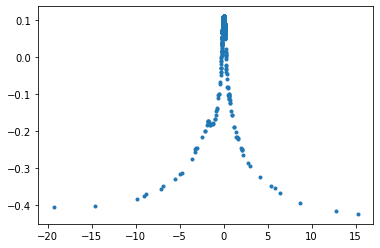

In [54]:
# TODO: think about how to visualize this 
plt.plot(df['number'],df['scores'].loc, '.')